In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [26]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state_list, target):
    fig, ax = plt.subplots( 1,1, figsize=(8,4), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)
    fs_ = 16

    state = state_list[0]
    ax.plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax.plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    for state in state_list[1:]:
        ax.plot(t_array, state[0,0,:], color=color_x, linewidth=1)
        ax.plot(t_array, state[0,1,:], color=color_y, linewidth=1)

    ax.plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax.plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax.legend(loc="upper left", fontsize=fs_)
    ax.set_xlabel("Time [ms]", fontsize=fs_)
    ax.set_ylabel("Activity", fontsize=fs_)
    ax.set_title("Activity without stimulation and target activity", fontsize=fs_)
    ax.tick_params(axis='both', which='major', labelsize=fs_)
    ax.set_xlim(0,duration)

    plt.show()

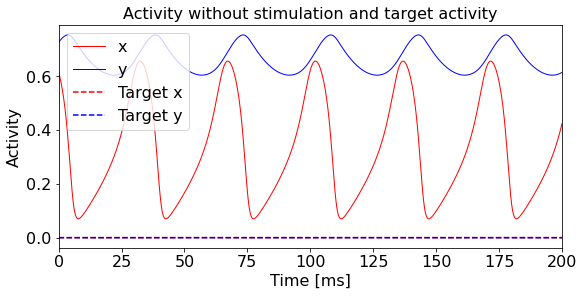

In [29]:
fhn = FHNModel()
fhn.params.sigma_ou = 0.
fhn.params.x_ou_mean = 0.

dt = fhn.params["dt"]
duration = 200.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn.run()

target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

fhn.params.x_ou_mean = 0.8
fhn.run()
x_init_osc = np.array([[fhn.x[0,-1]]])
y_init_osc = np.array([[fhn.y[0,-1]]])
fhn.params["xs_init"] = x_init_osc
fhn.params["ys_init"] = y_init_osc
fhn.run()

state_list = []

state_list.append(np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2) )

plot_singlenode(fhn, duration, dt, state_list, target)

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Compute control for a deterministic system
Cost in iteration 0: 296.20244963042
diverging model output, decrease step size to  0.5
diverging model output, decrease step size to  0.25
diverging model output, decrease step size to  0.125
diverging model output, decrease step size to  0.0625
diverging model output, decrease step size to  0.03125
Cost in iteration 1: 257.30766088634846
Final cost : 257.30766088634846


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

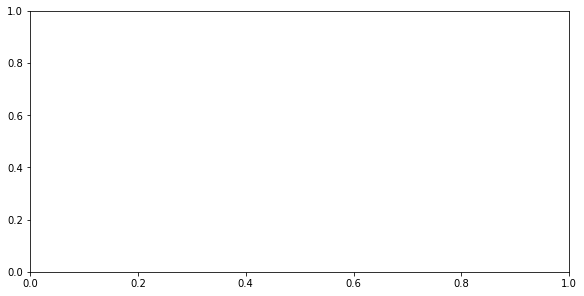

In [30]:
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
w2 = 1e-2
wp = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100)) )
fhn_controlled_noisefree = oc_fhn.OcFhn(fhn, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(1000,None))

# We run 100 iterations of the optimal control gradient descent algorithm
fhn_controlled_noisefree.step = 1.
fhn_controlled_noisefree.optimize(1)

state_list.append(fhn_controlled_noisefree.get_xs() )
control_noisefree = fhn_controlled_noisefree.control

plot_singlenode(fhn_controlled_noisefree.model, duration, dt, state_list, target)


Compute control for a deterministic system
Cost in iteration 0: 0.6687210081606866
Cost in iteration 1: 0.668602068205939
Cost in iteration 2: 0.6685175570017536
Cost in iteration 3: 0.6683698373036536
Cost in iteration 4: 0.6683590968816049
Cost in iteration 5: 0.6681567900689399
Cost in iteration 6: 0.6680299814434751
Cost in iteration 7: 0.6679755822672565
Cost in iteration 8: 0.6678111700570257
Cost in iteration 9: 0.6676999848359068
Cost in iteration 10: 0.6676156657372293
Cost in iteration 11: 0.667478826173936
Cost in iteration 12: 0.6674599875558911
Cost in iteration 13: 0.6672747120096554
Cost in iteration 14: 0.6671571032180917
Cost in iteration 15: 0.6670986376010379
Cost in iteration 16: 0.6669479810466846
Cost in iteration 17: 0.6668445880892975
Cost in iteration 18: 0.6667592816069604
Cost in iteration 19: 0.6666335587956619
Cost in iteration 20: 0.6666051462673027
Cost in iteration 21: 0.666437424470412
Cost in iteration 22: 0.6663289990839222
Cost in iteration 23: 0.666

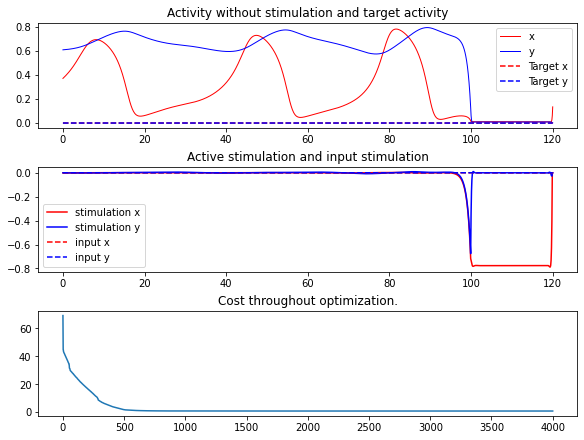

In [5]:
fhn_controlled_noisefree.optimize(3000)

state = fhn_controlled_noisefree.get_xs()
control_noisefree = fhn_controlled_noisefree.control

plot_singlenode(fhn_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, fhn_controlled_noisefree.cost_history)

In [6]:
sigma_array = [2. * 1e-3, 1.* 1e-2]
M_array = [4,20,100]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None] ]
costs_history = [ [None, None, None], [None, None, None] ]
costs = np.zeros(( len(sigma_array), len(M_array)+1 ))

In [20]:
fhn_noise = FHNModel()
fhn_noise.params.sigma_ou = 0.
fhn_noise.params.x_ou_mean = 0.

In [21]:
fhn_noise.params.duration = 1. * 1e6
fhn_noise.params["xs_init"] = np.array([[x_init]])
fhn_noise.params["ys_init"] = np.array([[y_init]])
fhn_noise.params["x_ext"] = zero_input
fhn_noise.params["y_ext"] = zero_input

for i_s in range(len(sigma_array)):
    fhn_noise.params.sigma_ou = sigma_array[i_s]

    fhn_noise.run()
    weights[i_s] = 1. / (np.std(fhn_noise.x[0,100:]) + np.std(fhn_noise.y[0,100:]) )

print(weights)

[22.97867797  3.97503799]


In [22]:
fhn_noise.params.duration = duration
fhn_noise.params["xs_init"] = x_init_osc
fhn_noise.params["ys_init"] = y_init_osc

fhn_noise.params.x_ou_mean = 0.8
M_val = 500
max_iterations = 2000
fhn_noise.run()
printarray = np.concatenate( (np.arange(0,100,10), np.arange(0,2001,100)) )

#costs_history = [ [None, None, None, None], [None, None, None, None], [None, None, None, None] ]

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in []:
            continue

        if i_s in []:
            continue

        if type(costs_history[i_s][i_m]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        fhn_noise.params["x_ext"] = zero_input
        fhn_noise.params["y_ext"] = zero_input
        fhn_noise.params.sigma_ou = sigma_array[i_s]

        fhn_controlled_models = oc_fhn.OcFhn(fhn_noise, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=[1000,None],
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True)

        fhn_controlled_models.step = 0.01

        # We run 100 iterations of the optimal control gradient descent algorithm
        fhn_controlled_models.optimize(max_iterations)

        state = fhn_controlled_models.get_xs()
        controls[i_s][i_m] = fhn_controlled_models.control
        costs_history[i_s][i_m] = fhn_controlled_models.cost_history
        costs[i_s][i_m+1] = fhn_controlled_models.cost_validation

        # plot_singlenode(fhn_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, fhn_controlled_models.cost_history, M=10)

In [23]:
fhn_plot = FHNModel()
fhn_plot.params.x_ou_mean = 0.8

fhn_plot.params["duration"] = duration
fhn_plot.params["xs_init"] = x_init_osc
fhn_plot.params["ys_init"] = y_init_osc


In [30]:
for i_s in range(len(sigma_array)):

    print(i_s)

    fhn_plot.params.sigma_ou = sigma_array[i_s]

    fhn_plot.params["x_ext"] = control_noisefree[:,0,:]
    fhn_plot.params["y_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        fhn_plot.run()
        state = np.concatenate((np.concatenate( (fhn_plot.params["xs_init"], fhn_plot.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn_plot.x, fhn_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, wp, 1, np.ones( (1, 2)), [1000,-1])
        cost_validation += precision_cost

    costs[i_s][0] =  energy_cost + cost_validation/M_val

print(costs[0][0], costs[1][0])

0
1
0.7299895558151007 3.756553063563364


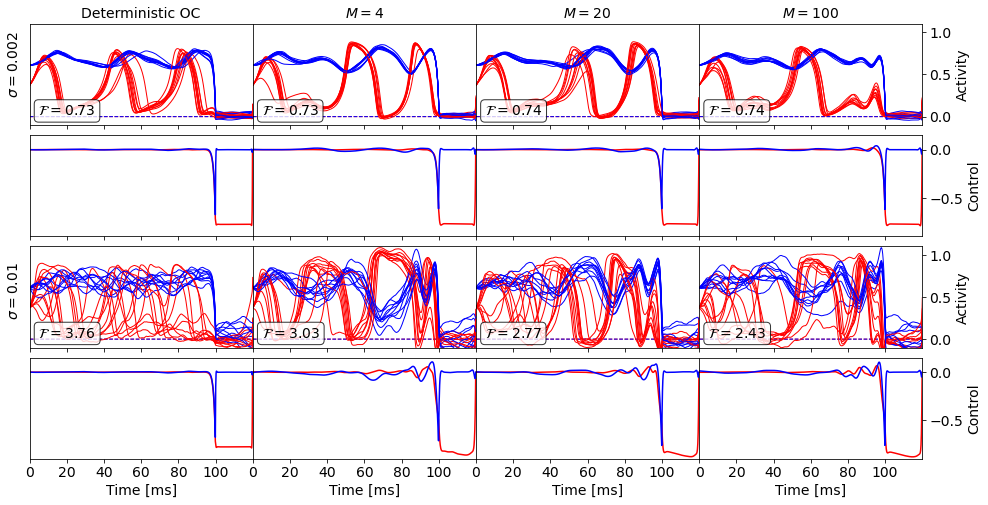

In [85]:
row, col = int(2*len(sigma_array)), int(len(M_array)+1)

fig = plt.figure(figsize=(4*col,2*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    fhn_plot.params.sigma_ou = sigma_array[i_s]

    fhn_plot.params["x_ext"] = control_noisefree[:,0,:]
    fhn_plot.params["y_ext"] = control_noisefree[:,1,:]

    ax[2*i_s, 0].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
    ax[2*i_s, 0].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

    for m in range(10):
        fhn_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], fhn_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], fhn_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, 0].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][i_m+1]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        fhn_plot.params["x_ext"] = controls[i_s][i_m][:,0,:]
        fhn_plot.params["y_ext"] = controls[i_s][i_m][:,1,:]

        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

        for m in range(10):
            fhn_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], fhn_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], fhn_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])

    for k in range(col):
        ax[2*i_s,k].set_ylim([-0.1, 1.1])
        ax[2*i_s+1,k].set_ylim([-.9, 0.15])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)
    

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

fig.savefig(os.path.join(savepath, 'FHN_osc_down_traces.jpg'), bbox_inches='tight')
plt.show()


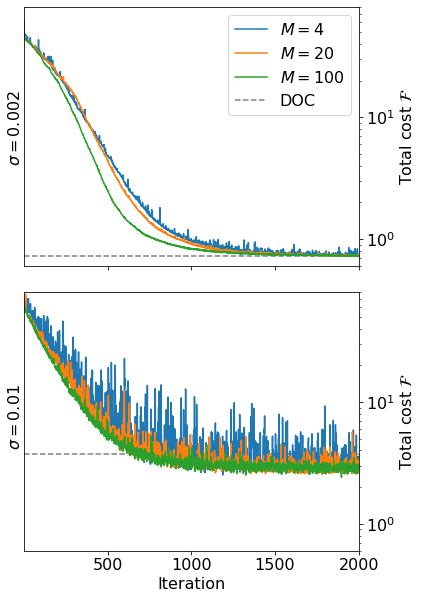

In [88]:
row, col = len(sigma_array), 1

fig = plt.figure(figsize=(6,5*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
fs = 16

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):
        ax[i_s].plot(costs_history[i_s][i_m], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].hlines(costs[i_s,0], 0, max_iterations, label='DOC', linestyle='--', color='grey')

    ax[i_s].text(-0.05, 0.4, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)
    ax[i_s].set_xlim([1,max_iterations])
    ax[i_s].set_yscale('log')
    ax[i_s].set_ylim(0.6, 80)

ax[0].legend(loc='upper right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)


fig.savefig(os.path.join(savepath, 'FHN_osc_down_cost.jpg'), bbox_inches='tight')
plt.show()